# License

Copyright 2018 Hamaad Musharaf Shah

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Automatic feature engineering using Generative Adversarial Networks: Application to computer vision and synthetic financial transactions data
## Author: Hamaad Shah

---

The purpose of deep learning is to learn a representation of high dimensional and noisy data using a sequence of differentiable functions, i.e., geometric transformations, that can perhaps be used for supervised learning tasks among others. It has had great success in discriminative models while generative models have fared worse due to the limitations of explicit maximum likelihood estimation (MLE). Adversarial learning as presented in the Generative Adversarial Network (GAN) aims to overcome these problems by using implicit MLE. 

We will use the MNIST computer vision dataset and a synthetic financial transactions dataset for an insurance task for these experiments. GAN is a remarkably different method of learning compared to explicit MLE. Our purpose will be to show that the representation learnt by a GAN can be used for supervised learning tasks such as image recognition and insurance loss risk prediction. In this manner we avoid the manual process of handcrafted feature engineering by learning a set of features automatically, i.e., representation learning.

In [ ]:
# License
# Copyright 2018 Hamaad Musharaf Shah
# Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

import math
import inspect

import tensorflow

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score

from scipy.stats import norm

import keras
from keras import backend as bkend
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.utils.generic_utils import Progbar
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.python.client import device_lib

from gan_keras.loss_history import LossHistory

class DeepConvGenAdvNet(BaseEstimator, 
                        TransformerMixin):
    def __init__(self, 
                 z_size=None,
                 iterations=None,
                 batch_size=None):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
        
        self.dl4j_res_path = "/Users/samson/Projects/gan_deeplearning4j/Java/src/main/resources/"

        # Build the discriminator.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer=RMSprop(lr=0.0002, 
                                                     clipvalue=1.0,
                                                     decay=1e-8),
                                   loss="binary_crossentropy")
        self.discriminator.save(self.dl4j_res_path + "discriminator.h5")

        # Build the generator to fool the discriminator.
        # Freeze the discriminator here.
        self.generator = self.build_generator()
        GAN_input = Input(shape=(self.z_size,),
                          name="gen_input_layer_0")

        GAN_fake = None
        for i in range(1, len(self.generator.layers)):
            if i == 1:
                GAN_fake = self.generator.layers[i](GAN_input)
            else:
                GAN_fake = self.generator.layers[i](GAN_fake)
        
        GAN_output = None
        for i in range(1, len(self.discriminator.layers)):
            if i == 1:
                GAN_output = self.discriminator.layers[i](GAN_fake)
            else:
                GAN_output = self.discriminator.layers[i](GAN_output)

        # Build the GAN.
        self.GAN = Model(GAN_input, GAN_output)
        for i in range(5, 0, -1):
            self.GAN.layers[-i].trainable = False
        self.GAN.compile(optimizer=RMSprop(lr=0.0004, 
                                           clipvalue=1.0,
                                           decay=1e-8),
                         loss="binary_crossentropy")           
        self.GAN.save(self.dl4j_res_path + "generator.h5")
        
    def fit(self,
            X,
            y=None):
        num_train = X.shape[0]
        start = 0
        
        for step in range(self.iterations):
            # Generate a new batch of noise...
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))
            # ...and generate a batch of fake images.
            generated_images = self.generator.predict(noise)
            
            stop = start + self.batch_size
            # Get a batch of real images.
            image_batch = X[start:stop]

            # [real, fake].
            x = np.concatenate((image_batch, generated_images))
            # [real, fake].
            y = np.concatenate([np.ones(shape=(self.batch_size, 1)), np.zeros(shape=(self.batch_size, 1))])
            y += 0.05 * np.random.random(size=y.shape)

            # See if the discriminator can figure itself out.
            self.d_loss = self.discriminator.train_on_batch(x, y)

            # Make new noise.
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))

            # We want to train the generator to trick the discriminator.
            # For the generator, we want all the [real, fake] labels to say real.
            trick = np.ones(shape=(self.batch_size, 1))

            self.gan_loss = self.GAN.train_on_batch(noise, trick)
                
            start += self.batch_size
            if start > num_train - self.batch_size:
                start = 0
            
            if step % 100 == 0:
                print("Step:", step)
                print("Discriminator loss:", self.d_loss)
                print("GAN loss:", self.gan_loss)
                
                img = image.array_to_img(generated_images[0] * 255.0, scale=False)
                img.save("outputs/generated_image" + str(step) + ".png")
                
                img = image.array_to_img(image_batch[0] * 255.0, scale=False)
                img.save("outputs/real_image" + str(step) + ".png")

        return self

    def transform(self,
                  X):
        return self.feature_extractor.predict(X)

    def build_generator(self):
        # We will map z, a latent vector, to image space (..., 28, 28, 1).
        latent = Input(shape=(self.z_size,),
                       name="gen_input_layer_0")

        # This produces a (..., 7, 7, 128) shaped tensor.
        cnn = Dense(units=1024, 
                    activation="tanh",
                    name="gen_dense_layer_1")(latent)
        cnn = Dense(units=128 * 7 * 7, 
                    activation="tanh",
                    name="gen_dense_layer_2")(cnn)
        cnn = BatchNormalization(name="gen_batch_layer_3")(cnn)
        cnn = Reshape((7, 7, 128),
                      name="gen_reshape_layer_4")(cnn)

        # Upsample to (..., 14, 14, 64).
        cnn = UpSampling2D(size=(2, 2),
                           name="gen_upsample2d_layer_5")(cnn)
        cnn = layers.Conv2D(filters=64, 
                            kernel_size=(5, 5), 
                            strides=(1, 1), 
                            padding="same", 
                            activation="tanh",
                            name="gen_conv2d_layer_6")(cnn)

        # Upsample to (..., 28, 28, 64).
        cnn = UpSampling2D(size=(2, 2),
                           name="gen_upsample2d_layer_7")(cnn)

        # Take a channel axis reduction to (..., 28, 28, 1).
        fake_img = Conv2D(filters=1, 
                          kernel_size=(5, 5), 
                          strides=(1, 1), 
                          padding="same",
                          activation="sigmoid", 
                          kernel_initializer="glorot_normal",
                          name="gen_output_layer_8")(cnn)

        return Model(latent, fake_img)
    
    def build_discriminator(self):
        image = Input(shape=(28, 28, 1),
                      name="dis_input_layer_0")

        cnn = Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     padding="same", 
                     strides=(2, 2), 
                     activation="tanh",
                     name="dis_conv2d_layer_1")(image)
        cnn = layers.MaxPooling2D(pool_size=(2, 2),
                                  name="dis_maxpool2d_layer_2")(cnn)
        cnn = Conv2D(filters=128, 
                     kernel_size=(5, 5),
                     padding="same", 
                     strides=(2, 2), 
                     activation="tanh",
                     name="dis_conv2d_layer_3")(cnn)
        cnn = layers.GlobalAveragePooling2D(name="dis_globalavgpool2d_layer_4")(cnn)

        is_real_img = Dense(units=1, 
                            activation="sigmoid",
                            name="dis_output_layer_5")(cnn)     

        return Model(image, is_real_img)            
            
    def evaluate(self,
                 X):
        num_test = X.shape[0]

        # Generate a new batch of noise.
        noise = np.random.uniform(low=-1.0, high=1.0, size=(num_test, self.z_size))
        generated_images = self.generator.predict(noise)

        # [real, fake].
        x = np.concatenate((X, generated_images))
        # [real, fake].
        y = np.concatenate([np.ones(shape=(num_test, 1)), np.zeros(shape=(num_test, 1))])
        y += 0.05 * np.random.random(size=y.shape)

        self.d_test_loss = self.discriminator.evaluate(x, y)

        # Make new noise.
        noise = np.random.uniform(low=-1.0, high=1.0, size=(num_test, self.z_size))
        trick = np.ones(shape=(num_test, 1))

        self.gan_test_loss = self.GAN.evaluate(noise, trick)
        
        return [self.d_test_loss, self.gan_test_loss]
    
class DeeperConvGenAdvNet(DeepConvGenAdvNet):
    def __init__(self,
                 z_size=None,
                 iterations=None,
                 batch_size=None):
        super(DeeperConvGenAdvNet, self).__init__(z_size=z_size,
                                                  iterations=iterations,
                                                  batch_size=batch_size)
        
    def build_discriminator(self):
        image = Input(shape=(28, 28, 1))

        cnn = Conv2D(filters=100, kernel_size=(8, 8), padding="same", strides=(1, 1), activation="elu")(image)
        cnn = Dropout(rate=0.5)(cnn)
        cnn = Conv2D(filters=100, kernel_size=(8, 8), padding="same", strides=(1, 1), activation="elu")(cnn)
        cnn = Dropout(rate=0.5)(cnn)
        cnn = Conv2D(filters=100, kernel_size=(8, 8), padding="same", strides=(1, 1), activation="elu")(cnn)
        cnn = layers.MaxPooling2D(pool_size=(4, 4))(cnn)
        cnn = Flatten()(cnn)
        self.feature_extractor = Model(image, cnn)

        is_real_img = Dense(units=1, activation="sigmoid", name="discriminator")(cnn)     
        
        return Model(image, is_real_img)
    
class DeepConvGenAdvNetInsurance(DeepConvGenAdvNet):
    def __init__(self,
                 z_size=None,
                 iterations=None,
                 batch_size=None):
        super(DeepConvGenAdvNetInsurance, self).__init__(z_size=z_size,
                                                         iterations=iterations,
                                                         batch_size=batch_size)
        
    def build_generator(self):
        # We will map z, a latent vector, to image space (..., 4, 3, 1).
        latent = Input(shape=(self.z_size,))

        # This produces a (..., 4, 3, 1) shaped tensor.
        cnn = Dense(units=100, activation="tanh")(latent)
        cnn = Dense(units=100, activation="tanh")(cnn)
        cnn = Dense(units=100, activation="tanh")(cnn)
        cnn = Dense(units=1 * 3 * 4, activation="sigmoid")(cnn)
        fake_input_ = Reshape((4, 3, 1))(cnn)

        return Model(latent, fake_input_)
        
    def build_discriminator(self):
        input_ = Input(shape=(4, 3, 1))

        cnn = Flatten()(input_)
        cnn = Dense(units=100, activation="elu")(cnn)
        cnn = Dropout(rate=0.5)(cnn)
        self.feature_extractor = Model(input_, cnn)

        is_real_input_ = Dense(units=1, activation="sigmoid", name="discriminator")(cnn)     
        
        return Model(input_, is_real_input_)

In [20]:
# Author: Hamaad Musharaf Shah.
from PIL import Image

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import keras
from keras import backend as bkend
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.utils.generic_utils import Progbar

import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt

from plotnine import *
import plotnine

from gan_keras.dcgan import DeepConvGenAdvNet, DeeperConvGenAdvNet, DeepConvGenAdvNetInsurance

get_ipython().magic("matplotlib inline")

os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)

print(device_lib.list_local_devices())

mnist = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1], x_train.shape[2], 1])
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1], x_test.shape[2], 1])
y_train = y_train.ravel()
y_test = y_test.ravel()
x_train = x_train.astype("float16")
x_test = x_test.astype("float16")
x_train /= 255.0
x_test /= 255.0

scaler_classifier = MinMaxScaler(feature_range=(0.0, 1.0))
logistic = linear_model.LogisticRegression(random_state=666, verbose=1)
lb = LabelBinarizer()
lb = lb.fit(y_train.reshape(y_train.shape[0], 1))

dl4j_res_path = "/Users/samson/Projects/gan_deeplearning4j/Java/src/main/resources/"

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16744658543566176647
]


In [21]:
np.savetxt(fname=dl4j_res_path + "mnist_train.csv",
           X=np.hstack([x_train.reshape([-1, x_train.shape[1] * x_train.shape[2]]), 
                        y_train.reshape([-1, 1])]),
           fmt="%.4e",
           delimiter=",",
           newline="\n",
           header="")

np.savetxt(fname=dl4j_res_path + "mnist_test.csv",
           X=np.hstack([x_test.reshape([-1, x_test.shape[1] * x_test.shape[2]]),
                        y_test.reshape([-1, 1])]),
           fmt="%.4e",
           delimiter=",",
           newline="\n",
           header="")

In [ ]:
inputs = Input(shape=(x_test.shape[1] * x_test.shape[2],))
feat_eng = Dense(500, activation="elu")(inputs)
feat_eng = Dropout(rate=0.5)(feat_eng)
feat_eng = BatchNormalization()(feat_eng)
feat_eng = Dense(400, activation="elu")(feat_eng)
feat_eng = Dropout(rate=0.5)(feat_eng)
feat_eng = BatchNormalization()(feat_eng)
feat_eng = Dense(300, activation="elu")(feat_eng)
output = Dense(10, activation="softmax")(feat_eng)
model = Model(inputs=inputs, outputs=output)
model.compile(loss="categorical_crossentropy",
              optimizer="sgd", 
              metrics=["accuracy"])
model.save(dl4j_res_path + "mlp_fnctl.h5")

dcgan = DeepConvGenAdvNet(batch_size=100,
                          iterations=10000,
                          z_size=2)
dcgan.discriminator.save(dl4j_res_path + "discriminator.h5")
dcgan.GAN.save(dl4j_res_path + "generator.h5")

In [ ]:
np.hstack([x_train.reshape([-1, x_train.shape[1] * x_train.shape[2]]), y_train.reshape([-1, 1])]).shape

In [ ]:
dcgan = DeepConvGenAdvNet(batch_size=100,
                          iterations=10000,
                          z_size=2)
dcgan.discriminator.summary()
dcgan.GAN.summary()

In [ ]:
[dcgan.GAN.layers[i].trainable for i in range(len(dcgan.GAN.layers))]

In [ ]:
from keras.models import load_model
loaded_model = load_model(dl4j_res_path + "generator.h5")

In [ ]:
[loaded_model.layers[i].trainable for i in range(len(loaded_model.layers))]

In [ ]:
json_string = loaded_model.to_json()
with open(dl4j_res_path + "generator.json", "w") as json_file:
    json_file.write(json_string)

/Users/samson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


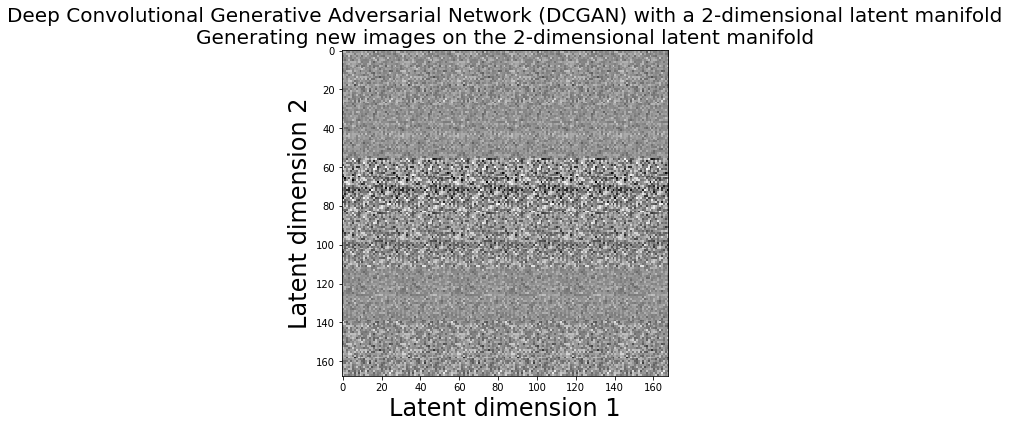

In [23]:
dl4j_res_path = "/Users/samson/Projects/gan_deeplearning4j/Java/src/main/resources/"
out = pd.read_csv(filepath_or_buffer=dl4j_res_path + "out.csv",
                  header=None)
digit_size = 28
n = 36
figure = np.zeros((digit_size * int(np.power(n, 0.5)), digit_size * int(np.power(n, 0.5))))

for i in range(int(np.power(n, 0.5))):
    for j in range(int(np.power(n, 0.5))):
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = out.iloc[i].reshape(digit_size, digit_size)
        
plt.figure(figsize=(np.power(n, 0.5), np.power(n, 0.5)))
plt.title("Deep Convolutional Generative Adversarial Network (DCGAN) with a 2-dimensional latent manifold\nGenerating new images on the 2-dimensional latent manifold", fontsize=20)
plt.xlabel("Latent dimension 1", fontsize=24)
plt.ylabel("Latent dimension 2", fontsize=24)
plt.imshow(figure, cmap="Greys")

## Generative Adversarial Network

---

There are 2 main components to a GAN, the generator and the discriminator, that play an adversarial game against each other. In doing so the generator learns how to create realistic synthetic samples from noise, i.e., the latent space $z$, while the discriminator learns how to distinguish between a real sample and a synthetic sample. 

The representation learnt by the discriminator can later on be used for other supervised learning tasks, i.e., automatic feature engineering or representation learning. This can also be viewed through the lens of transfer learning. A GAN can also be used for semi-supervised learning which we will get to in another paper where we will look into using variational autoencoders, ladder networks and adversarial autoencoders for this purpose.

### Computer Vision

---

We will use the MNIST dataset for this purpose where the raw data is a 2 dimensional tensor of pixel intensities per image. The image is our unit of analysis: We will predict the probability of each class for each image. This is a multiclass classification task and we will use the accuracy score to assess model performance on the test fold.

![](pixel_lattice.png)

Some examples of handcrafted feature engineering for the computer vision task perhaps might be using Gabor filters.

### Insurance

---

We will use a synthetic dataset where the raw data is a 2 dimensional tensor of historical policy level information per policy-period combination: Per unit this will be a 4 by 3 dimensional tensor, i.e., 4 historical time periods and 3 transactions types. The policy-period combination is our unit of analysis: We will predict the probability of loss for time period 5 in the future — think of this as a potential renewal of the policy for which we need to predict whether it would make a loss for us or not hence affecting whether we decided to renew the policy and / or adjust the renewal premium to take into account the additional risk. This is a binary class classification task and we will use the AUROC score to assess model performance.

![](trans_lattice.png)

Some examples of handcrafted feature engineering for the insurance task perhaps might be using column or row averages.

The synthetic insurance financial transactions dataset was coded in R. All the rest of the work is done in Python.

Please note the similarities between the raw data for the computer vision task and the raw data for the insurance task. Our main goal here is to learn a good representation of this raw data using automatic feature engineering via GANs.

### Scikit-learn, Keras and TensorFlow

---

We will use the Python machine learning library scikit-learn for data transformation and the classification task. We will code the GANs as scikit-learn transformers such that they can be readily used by scikit-learn pipelines. The GANs will be coded using Keras with the TensorFlow backend. We also use an external GPU, i.e., GTX 1070, on a MacBook Pro.

### Generator

---

Assume that we have a prior belief on where the latent space $z$ lies: $p(z)$. Given a draw from this latent space the generator $G$, a deep learner parameterized by $\theta_{G}$, outputs a synthetic sample.

$$
G(z|\theta_{G}): z \rightarrow x_{synthetic}
$$ 

### Discriminator

---

The discriminator $D$ is another deep learner parameterized by $\theta_{D}$ and it aims to classify if a sample is real or synthetic, i.e., if a sample is from the real data distribution,

$$
P_{\text{data}}
$$ 

or the synthetic data distribution.

$$
P_{G}
$$

Let us denote the discriminator $D$ as follows.

$$
D(x|\theta_{D}): x \rightarrow [0, 1]
$$ 

Here we assume that the positive examples are from the real data distribution while the negative examples are from the synthetic data distribution.

### Game: Optimality

---

A GAN simultaneously trains the discriminator to correctly classify real and synthetic examples while training the generator to create synthetic examples such that the discriminator incorrectly classifies real and synthetic examples. This 2 player minimax game has the following objective function.

$$
\min_{G(z|\theta_{G})} \max_{D(x|\theta_{D})} V(D(x|\theta_{D}), G(z|\theta_{G})) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{D(x|\theta_{D})} + \mathbb{E}_{z \sim p(z)} \log{(1 - D(G(z|\theta_{G})|\theta_{D}))}
$$

Please note that the above expression is basically the objective function of the discriminator.

$$
\mathbb{E}_{x \sim p_{\text{data}}(x)} \log{D(x|\theta_{D})} + \mathbb{E}_{x \sim p_{G}(x)} \log{(1 - D(x|\theta_{D}))}
$$

It is clear from how the game has been set up that we are trying to obtain a solution $\theta_{D}$ for $D$ such that it maximizes $V(D, G)$ while simultaneously we are trying to obtain a solution $\theta_{G}$ for $G$ such that it minimizes $V(D, G)$.

We do not simultaneously train $D$ and $G$. We train them alternately: Train $D$ and then train $G$ while freezing $D$. We repeat this for a fixed number of steps.

If the synthetic samples taken from the generator $G$ are realistic then implicitly we have learnt the distribution $P_{G}$. In other words, $P_{G}$ can be seen as a good estimation of $P_{\text{data}}$. The optimal solution will be as follows.

$$
P_{G}=P_{\text{data}}
$$

To show this let us find the optimal discriminator $D^\ast$ given a generator $G$ and sample $x$. 

\begin{align*}
V(D, G) &= \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{D(x|\theta_{D})} + \mathbb{E}_{x \sim p_{G}(x)} \log{(1 - D(x|\theta_{D}))} \\
&= \int_{x} p_{\text{data}}(x) \log{D(x|\theta_{D})} dx + \int_{x} p_{G}(x) \log{(1 - D(x|\theta_{D}))} dx \\
&= \int_{x} \underbrace{p_{\text{data}}(x) \log{D(x|\theta_{D})} + p_{G}(x) \log{(1 - D(x|\theta_{D}))}}_{J(D(x|\theta_{D}))} dx
\end{align*}

Let us take a closer look at the discriminator's objective function for a sample $x$.

\begin{align*}
J(D(x|\theta_{D})) &= p_{\text{data}}(x) \log{D(x|\theta_{D})} + p_{G}(x) \log{(1 - D(x|\theta_{D}))} \\
\frac{\partial J(D(x|\theta_{D}))}{\partial D(x|\theta_{D})} &= \frac{p_{\text{data}}(x)}{D(x|\theta_{D})} - \frac{p_{G}(x)}{(1 - D(x|\theta_{D}))} \\
0 &= \frac{p_{\text{data}}(x)}{D^\ast(x|\theta_{D^\ast})} - \frac{p_{G}(x)}{(1 - D^\ast(x|\theta_{D^\ast}))} \\
p_{\text{data}}(x)(1 - D^\ast(x|\theta_{D^\ast})) &= p_{G}(x)D^\ast(x|\theta_{D^\ast}) \\
p_{\text{data}}(x) - p_{\text{data}}(x)D^\ast(x|\theta_{D^\ast})) &= p_{G}(x)D^\ast(x|\theta_{D^\ast}) \\
p_{G}(x)D^\ast(x|\theta_{D^\ast}) + p_{\text{data}}(x)D^\ast(x|\theta_{D^\ast})) &= p_{\text{data}}(x) \\
D^\ast(x|\theta_{D^\ast}) &= \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)} 
\end{align*}

We have found the optimal discriminator given a generator. Let us focus now on the generator's objective function which is essentially to minimize the discriminator's objective function.

\begin{align*}
J(G(x|\theta_{G})) &= \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{D^\ast(x|\theta_{D^\ast})} + \mathbb{E}_{x \sim p_{G}(x)} \log{(1 - D^\ast(x|\theta_{D^\ast}))} \\
&= \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{\bigg( \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) + \mathbb{E}_{x \sim p_{G}(x)} \log{\bigg(1 - \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} \\
&= \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{\bigg( \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) + \mathbb{E}_{x \sim p_{G}(x)} \log{\bigg(\frac{p_{G}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} \\
&= \int_{x} p_{\text{data}}(x) \log{\bigg( \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) dx + \int_{x} p_{G}(x) \log{\bigg(\frac{p_{G}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} dx
\end{align*}

We will note the Kullback–Leibler (KL) divergences in the above objective function for the generator.

$$
D_{KL}(P||Q) = \int_{x} p(x) \log\bigg(\frac{p(x)}{q(x)}\bigg) dx
$$

Recall the definition of a $\lambda$ divergence.

$$
D_{\lambda}(P||Q) = \lambda D_{KL}(P||\lambda P + (1 - \lambda) Q) + (1 - \lambda) D_{KL}(Q||\lambda P + (1 - \lambda) Q)
$$

If $\lambda$ takes the value of 0.5 this is then called the Jensen-Shannon (JS) divergence. This divergence is symmetric and non-negative.

$$
D_{JS}(P||Q) = 0.5 D_{KL}\bigg(P\bigg|\bigg|\frac{P + Q}{2}\bigg) + 0.5 D_{KL}\bigg(Q\bigg|\bigg|\frac{P + Q}{2}\bigg)
$$

Keeping this in mind let us take a look again at the objective function of the generator.

\begin{align*}
J(G(x|\theta_{G})) &= \int_{x} p_{\text{data}}(x) \log{\bigg( \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) dx + \int_{x} p_{G}(x) \log{\bigg(\frac{p_{G}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} dx \\
&= \int_{x} p_{\text{data}}(x) \log{\bigg(\frac{2}{2}\frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) dx + \int_{x} p_{G}(x) \log{\bigg(\frac{2}{2}\frac{p_{G}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} dx \\
&= \int_{x} p_{\text{data}}(x) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_{G}(x)}} \bigg) dx + \int_{x} p_{G}(x) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{G}(x)}{p_{\text{data}}(x) + p_{G}(x)}\bigg)} dx \\
&= \int_{x} p_{\text{data}}(x) \bigg[ \log(0.5) + \log{\bigg(\frac{p_{\text{data}}(x)}{0.5 (p_{\text{data}}(x) + p_{G}(x))}} \bigg) \bigg] dx \\ &+ \int_{x} p_{G}(x) \bigg[\log(0.5) + \log{\bigg(\frac{p_{G}(x)}{0.5 (p_{\text{data}}(x) + p_{G}(x))}\bigg) \bigg] } dx \\
&= \log\bigg(\frac{1}{4}\bigg) + \int_{x} p_{\text{data}}(x) \bigg[\log{\bigg(\frac{p_{\text{data}}(x)}{0.5 (p_{\text{data}}(x) + p_{G}(x))}} \bigg) \bigg] dx \\ 
&+ \int_{x} p_{G}(x) \bigg[\log{\bigg(\frac{p_{G}(x)}{0.5 (p_{\text{data}}(x) + p_{G}(x))}\bigg) \bigg] } dx \\
&= -\log(4) + D_{KL}\bigg(P_{\text{data}}\bigg|\bigg|\frac{P_{\text{data}} + P_{G}}{2}\bigg) + D_{KL}\bigg(P_{G}\bigg|\bigg|\frac{P_{\text{data}} + P_{G}}{2}\bigg) \\
&= -\log(4) + 2 \bigg(0.5 D_{KL}\bigg(P_{\text{data}}\bigg|\bigg|\frac{P_{\text{data}} + P_{G}}{2}\bigg) + 0.5 D_{KL}\bigg(P_{G}\bigg|\bigg|\frac{P_{\text{data}} + P_{G}}{2}\bigg)\bigg) \\
&= -\log(4) + 2D_{JS}(P_{\text{data}}||P_{G}) 
\end{align*}

It is clear from the objective function of the generator above that the global minimum value attained is $-\log(4)$ which occurs when the following holds.

$$
P_{G}=P_{\text{data}}
$$

When the above holds the Jensen-Shannon divergence, i.e., $D_{JS}(P_{\text{data}}||P_{G})$, will be zero. Hence we have shown that the optimal solution is as follows.

$$
P_{G}=P_{\text{data}}
$$

### Game: Convergence

---

Assuming that the discriminator is allowed to reach its optimum given a generator, then $P_{G}$ can be shown to converge to $P_{\text{data}}$. 

Consider the following objective function which has been previously shown to be convex with respect to $P_{G}$ as we found the global minimum at $-\log(4)$.

$$
U(D^\ast, P_{G}) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \log{D^\ast(x|\theta_{D^\ast})} + \mathbb{E}_{x \sim p_{G}(x)} \log{(1 - D^\ast(x|\theta_{D^\ast}))}
$$

Gradient descent is used by the generator to move towards the global minimum given an optimal discriminator. We will show that the gradient of the generator exists given an optimal discriminator, i.e., $\nabla_{P_{G}} U(D^\ast, P_{G})$, such that convergence of $P_{G}$ to $P_{\text{data}}$ is guaranteed.

Note that the following is a supremum of a set of convex functions where the set is indexed by the discriminator $D$: $U(D^\ast, P_{G})=\sup_{D} U(D, P_{G})$. Remember that the supremum is the least upper bound.

Let us recall a few definitions regarding gradients and subgradients. A vector $g \in \mathbb{R}^K$ is a subgradient of a function $f: \mathbb{R}^K \rightarrow \mathbb{R}$ at a point $x \in \mathbb{dom}(f)$ if $\forall z \in \mathbb{dom}(f)$, the following relationship holds:

$$
f(z) \geq f(x) + g^{T}(z - x)
$$

If $f$ is convex and differentiable then its gradient at a point $x$ is also the subgradient. Most importantly, a subgradient can exist even if $f$ is not differentiable.

The subgradients of the supremum of a set of convex functions include the subgradient of the function at the point where the supremum is attained. As mentioned earlier, we have already shown that $U(D^\ast, P_{G})$ is convex.

\begin{align*}
&U(D^\ast, P_{G})=\sup_{D} U(D, P_{G}) \\
&\nabla_{P_{G}} \sup_{D} U(D, P_{G}) \in \nabla_{P_{G}} U(D, P_{G}) \\
&\nabla_{P_{G}} U(D^\ast, P_{G}) \in \nabla_{P_{G}} U(D, P_{G})
\end{align*}

The gradient of the generator, $\nabla_{P_{G}} U(D^\ast, P_{G})$, is used to make incremental improvements to the objective function of the generator, $U(D^\ast, P_{G})$, given an optimal discriminator, $D^\ast$. Therefore convergence of $P_{G}$ to $P_{\text{data}}$ is guaranteed.

### Results

---

In these experiments we show the ability of the generator to create realistic synthetic examples for the MNIST dataset and the insurance dataset. We use a 2-dimensional latent manifold.

Finally we show that using the representation learnt by the discriminator we can attain competitive results to using other representation learning methods for the MNIST dataset and the insurance dataset such as a wide variety of autoencoders.

### Results: Generating new data

---

![](DCGAN_Generated_Images.png)

![](DeeperCGAN_Generated_Images.png)

![](DCGAN_Generated_Lattices.png)

### Results: GAN for representation learning

---

* The accuracy score for the MNIST classification task with DCGAN: 98.350000%.
* The accuracy score for the MNIST classification task with Deeper CGAN: 99.090000%.
* The AUROC score for the insurance classification task with DCGAN: 92.844125%.

### The insurance data: A closer look

With image data we can perhaps judge qualitatively whether the generated data makes sense. For financial transactions data this is not possible. However let's have a look at an example of a generated transactions lattice. Please note that all financial transactions data has been transformed to lie between 0 and 1. 

![](DCGAN_Generated_Lattice_Example.png)

If we use the same matplotlib code as applied to the image data to plot the above generated transactions lattice we get the following image. We can see that where we have the maximum value possible for a transaction, i.e., 1, that is colored as black, while where we have the minimum value possible for a transaction, i.e., 0, that is colored as white. Transactions values in between have some gray color.  

![](DCGAN_Generated_Lattice_Example_Plotted.png)

Finally let us compare the distributions of actual and generated transactions lattices to see whether generated values are similar to actual values. This is a simple sanity check and it seems appears that the distributions are fairly similar. 

Another way perhaps is to check if the features learnt by the discriminator are useful for a supervised learning task. This seems to be the case in our insurance data example.

![](Dens_Plots_Actual_Generated_Lattices.png)

In [ ]:
dcgan = DeepConvGenAdvNet(batch_size=100,
                          iterations=10000,
                          z_size=2)

pipe_dcgan = Pipeline(steps=[("DCGAN", dcgan),
                             ("scaler_classifier", scaler_classifier),
                             ("classifier", logistic)])
pipe_dcgan = pipe_dcgan.fit(x_train, y_train)

acc_dcgan = pipe_dcgan.score(x_test, y_test)

print("The accuracy score for the MNIST classification task with DCGAN: %.6f%%." % (acc_dcgan * 100))

n = 50
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1.0, 1.0, n)
grid_y = np.linspace(-1.0, 1.0, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = pipe_dcgan.named_steps["DCGAN"].generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap="Greys")
plt.title("Deep Convolutional Generative Adversarial Network (DCGAN) with a 2-dimensional latent manifold\nGenerating new images on the 2-dimensional latent manifold", fontsize=20)
plt.xlabel("Latent dimension 1", fontsize=24)
plt.ylabel("Latent dimension 2", fontsize=24)
plt.savefig(fname="DCGAN_Generated_Images.png")

In [ ]:
deepercgan = DeeperConvGenAdvNet(batch_size=100,
                                 iterations=10000,
                                 z_size=2)

pipe_deepercgan = Pipeline(steps=[("DeeperCGAN", deepercgan),
                                  ("scaler_classifier", scaler_classifier),
                                  ("classifier", logistic)])
pipe_deepercgan = pipe_deepercgan.fit(x_train, y_train)

acc_deepercgan = pipe_deepercgan.score(x_test, y_test)

print("The accuracy score for the MNIST classification task with Deeper CGAN: %.6f%%." % (acc_deepercgan * 100))

n = 50
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = pipe_deepercgan.named_steps["DeeperCGAN"].generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap="Greys")
plt.title("Deeper Convolutional Generative Adversarial Network (DCGAN) with a 2-dimensional latent manifold\nGenerating new images on the 2-dimensional latent manifold", fontsize=20)
plt.xlabel("Latent dimension 1", fontsize=24)
plt.ylabel("Latent dimension 2", fontsize=24)
plt.savefig(fname="DeeperCGAN_Generated_Images.png")

In [ ]:
claim_risk = pd.read_csv(filepath_or_buffer="data/claim_risk.csv")
claim_risk.drop(columns="policy.id", axis=1, inplace=True)
claim_risk = np.asarray(claim_risk).ravel()

transactions = pd.read_csv(filepath_or_buffer="data/transactions.csv")
transactions.drop(columns="policy.id", axis=1, inplace=True)

n_policies = 1000
n_transaction_types = 3
n_time_periods = 4

transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods * n_transaction_types))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)

min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train
transactions = (transactions - min_X_train) / range_X_train

X_train = np.reshape(np.asarray(X_train), (X_train.shape[0], n_time_periods, n_transaction_types, 1))
X_test = np.reshape(np.asarray(X_test), (X_test.shape[0], n_time_periods, n_transaction_types, 1))
transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods, n_transaction_types, 1))

dcgan_ins = DeepConvGenAdvNetInsurance(batch_size=50,
                                       iterations=5000,
                                       z_size=2)

pipe_dcgan_ins = Pipeline(steps=[("DCGANIns", dcgan_ins),
                                 ("scaler_classifier", scaler_classifier),
                                 ("classifier", logistic)])

pipe_dcgan_ins = pipe_dcgan_ins.fit(X_train, y_train)

auroc_dcgan_ins = roc_auc_score(y_true=y_test,
                                y_score=pipe_dcgan_ins.predict_proba(X_test)[:, 1], 
                                average="weighted")

print("The AUROC score for the insurance classification task with DCGAN: %.6f%%." % (auroc_dcgan_ins * 100))

n = 30
figure = np.zeros((n_time_periods * n, n_transaction_types * n))
plot_preds = np.zeros((n, n))

lattices = []
actual_lattices = []
grid_x = np.linspace(-1.0, 1.0, n)
grid_y = np.linspace(-1.0, 1.0, n)

counter = 0
for i in range(transactions.shape[0]):
    actual_lattices.append(pd.DataFrame(transactions[i, :, :, 0], columns=["Paid", "Reserves", "Recoveries"]))
    actual_lattices[counter]["Unit"] = counter
    actual_lattices[counter]["Time"] = ["Period 1", "Period 2", "Period 3", "Period 4"]
    actual_lattices[counter]["Type"] = "Actual"
    counter += 1

counter = 0
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = pipe_dcgan_ins.named_steps["DCGANIns"].generator.predict(z_sample)
        lattice = x_decoded[0].reshape(n_time_periods, n_transaction_types)
        lattices.append(pd.DataFrame(lattice, columns=["Paid", "Reserves", "Recoveries"]))
        lattices[counter]["Unit"] = counter
        lattices[counter]["Time"] = ["Period 1", "Period 2", "Period 3", "Period 4"]
        lattices[counter]["Type"] = "Generated"
        counter += 1
        figure[i * n_time_periods: (i + 1) * n_time_periods, j * n_transaction_types: (j + 1) * n_transaction_types] = lattice
        plot_preds[i: (i + 1), j: (j + 1)] = pipe_dcgan_ins.predict_proba(np.reshape(np.asarray(pd.DataFrame(lattice, columns=["Paid", "Reserves", "Recoveries"])), [-1, n_time_periods, n_transaction_types, 1]))[0][1]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(2, 1, 1)
plt.imshow(plot_preds, cmap="Greys")
plt.title("Deep Convolutional Generative Adversarial Network (DCGAN) with a 2-dimensional latent manifold for the insurance data\nPredicted probability of insurance loss", fontsize=20)
plt.xlabel("Latent dimension 1", fontsize=24)
plt.ylabel("Latent dimension 2", fontsize=24)
fig.add_subplot(2, 1, 2)
plt.imshow(figure, cmap="Greys")
plt.title("Deep Convolutional Generative Adversarial Network (DCGAN) with a 2-dimensional latent manifold for the insurance data\nGenerating new transactions data on the 2-dimensional latent manifold", fontsize=20)
plt.xlabel("Latent dimension 1", fontsize=24)
plt.ylabel("Latent dimension 2", fontsize=24)
plt.savefig(fname="DCGAN_Generated_Lattices.png")

tmp_act = pd.melt(pd.concat(actual_lattices, axis=0), id_vars=["Unit", "Time", "Type"])
tmp_gen = pd.melt(pd.concat(lattices, axis=0), id_vars=["Unit", "Time", "Type"])
plot_out = pd.concat([tmp_act, tmp_gen], axis=0)

plotnine.options.figure_size = (21, 15)
dens_plot = ggplot(plot_out) + \
geom_density(aes(x="value", fill="factor(Type)"), alpha=0.5, color="black") + \
xlab("Actual and generated data: Note that both lie on the [0, 1] interval") + \
ylab("Density") + \
facet_wrap(facets=["Time", "variable"], scales="free_y", ncol=3) + \
ggtitle("Deep Convolutional Generative Adversarial Network (DCGAN) for the insurance data\nA simple sanity check comparison of actual and generated transactions distributions") + \
theme(legend_position="bottom") + \
theme_matplotlib()
print(dens_plot)

dens_plot.save(filename="Dens_Plots_Actual_Generated_Lattices.png")

should_we_run = False
if should_we_run:
    i = j = 0
    plt.figure(figsize=(20, 30))
    plt.imshow(figure[i * n_time_periods: (i + 1) * n_time_periods, j * n_transaction_types: (j + 1) * n_transaction_types], cmap="Greys")
    plt.title("Showing an example of a generated transactions lattice", fontsize=24)
    plt.xlabel("Latent dimension 1", fontsize=24)
    plt.ylabel("Latent dimension 2", fontsize=24)
    plt.savefig(fname="DCGAN_Generated_Lattice_Example_Plotted.png")
    pd.DataFrame(lattices[i])

## Conclusion

---

We have shown how to use GANs to learn a good representation of raw data, i.e., 1 or 2 dimensional tensors per unit of analysis, that can then perhaps be used for supervised learning tasks in the domain of computer vision and insurance. This moves us away from manual handcrafted feature engineering towards automatic feature engineering, i.e., representation learning. GANs can perhaps be also used for semi-supervised learning which will be the topic of another paper.

## References

---

1. Goodfellow, I., Bengio, Y. and Courville A. (2016). Deep Learning (MIT Press).
2. Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & Tensorflow (O'Reilly).
3. Radford, A., Luke, M. and Chintala, S. (2015). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (https://arxiv.org/abs/1511.06434).
4. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., Bengio, Y. (2014). Generative Adversarial Networks (https://arxiv.org/abs/1406.2661).
5. http://scikit-learn.org/stable/#
6. https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
7. https://stackoverflow.com/questions/42177658/how-to-switch-backend-with-keras-from-tensorflow-to-theano
8. https://blog.keras.io/building-autoencoders-in-keras.html
9. https://keras.io
10. https://github.com/fchollet/keras/blob/master/examples/mnist_acgan.py#L24
11. https://en.wikipedia.org/wiki/Kullback–Leibler_divergence
12. https://see.stanford.edu/materials/lsocoee364b/01-subgradients_notes.pdf